# 자전거 수요 예측_ RandomForest_regression

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from os.path import join

In [4]:
path = './data/bike-sharing-demand'
train_path = join(path,'train.csv')
test_path = join(path,'test.csv')

train = pd.read_csv(train_path, parse_dates=['datetime'])
test = pd.read_csv(test_path, parse_dates=['datetime'])

In [5]:
train.head(), test.head()

(             datetime  season  holiday  workingday  weather  temp   atemp  \
 0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
 1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
 2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
 3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
 4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   
 
    humidity  windspeed  casual  registered  count  
 0        81        0.0       3          13     16  
 1        80        0.0       8          32     40  
 2        80        0.0       5          27     32  
 3        75        0.0       3          10     13  
 4        75        0.0       0           1      1  ,
              datetime  season  holiday  workingday  weather   temp   atemp  \
 0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
 1 2011-01-20 01:00:00       1        0           1  

In [6]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   

(None, None)

In [7]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [8]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [9]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

In [10]:
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0,5
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,1,6,0,0,5
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,1,7,0,0,5
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,1,8,0,0,5
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2011,1,1,9,0,0,5


<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

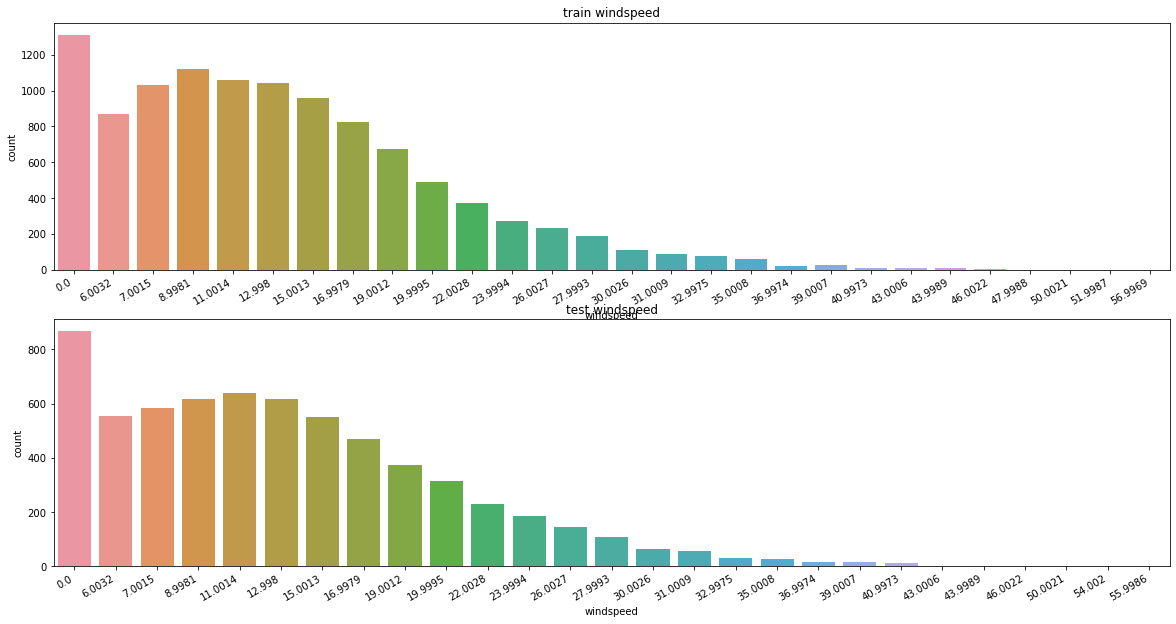

In [11]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(20,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

In [ ]:
# 의식 흐름
# data.head() : widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
# 풍속의 0값에 특정 값을 넣어준다. fillna=0 처리할까?
# EDA 분석: countplot()으로 데이터시각화 >> 0으로 일괄처리시, 이상치 있는 것과 같게 되겠네
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.

In [12]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0 = train.loc[train['windspeed']!=0]

trainWind0.shape, trainWindNot0.shape

((1313, 19), (9573, 19))

In [13]:
#  머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [14]:
train = predict_windspeed(train)
test = predict_windspeed(test)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,0,0,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,0,0,5


<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

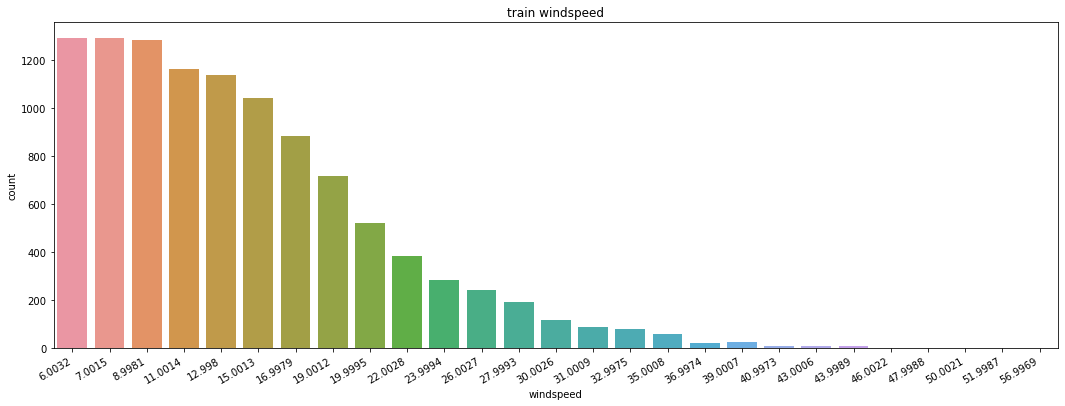

In [15]:
# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

In [ ]:
# 주요 변수 추출(feature selection)

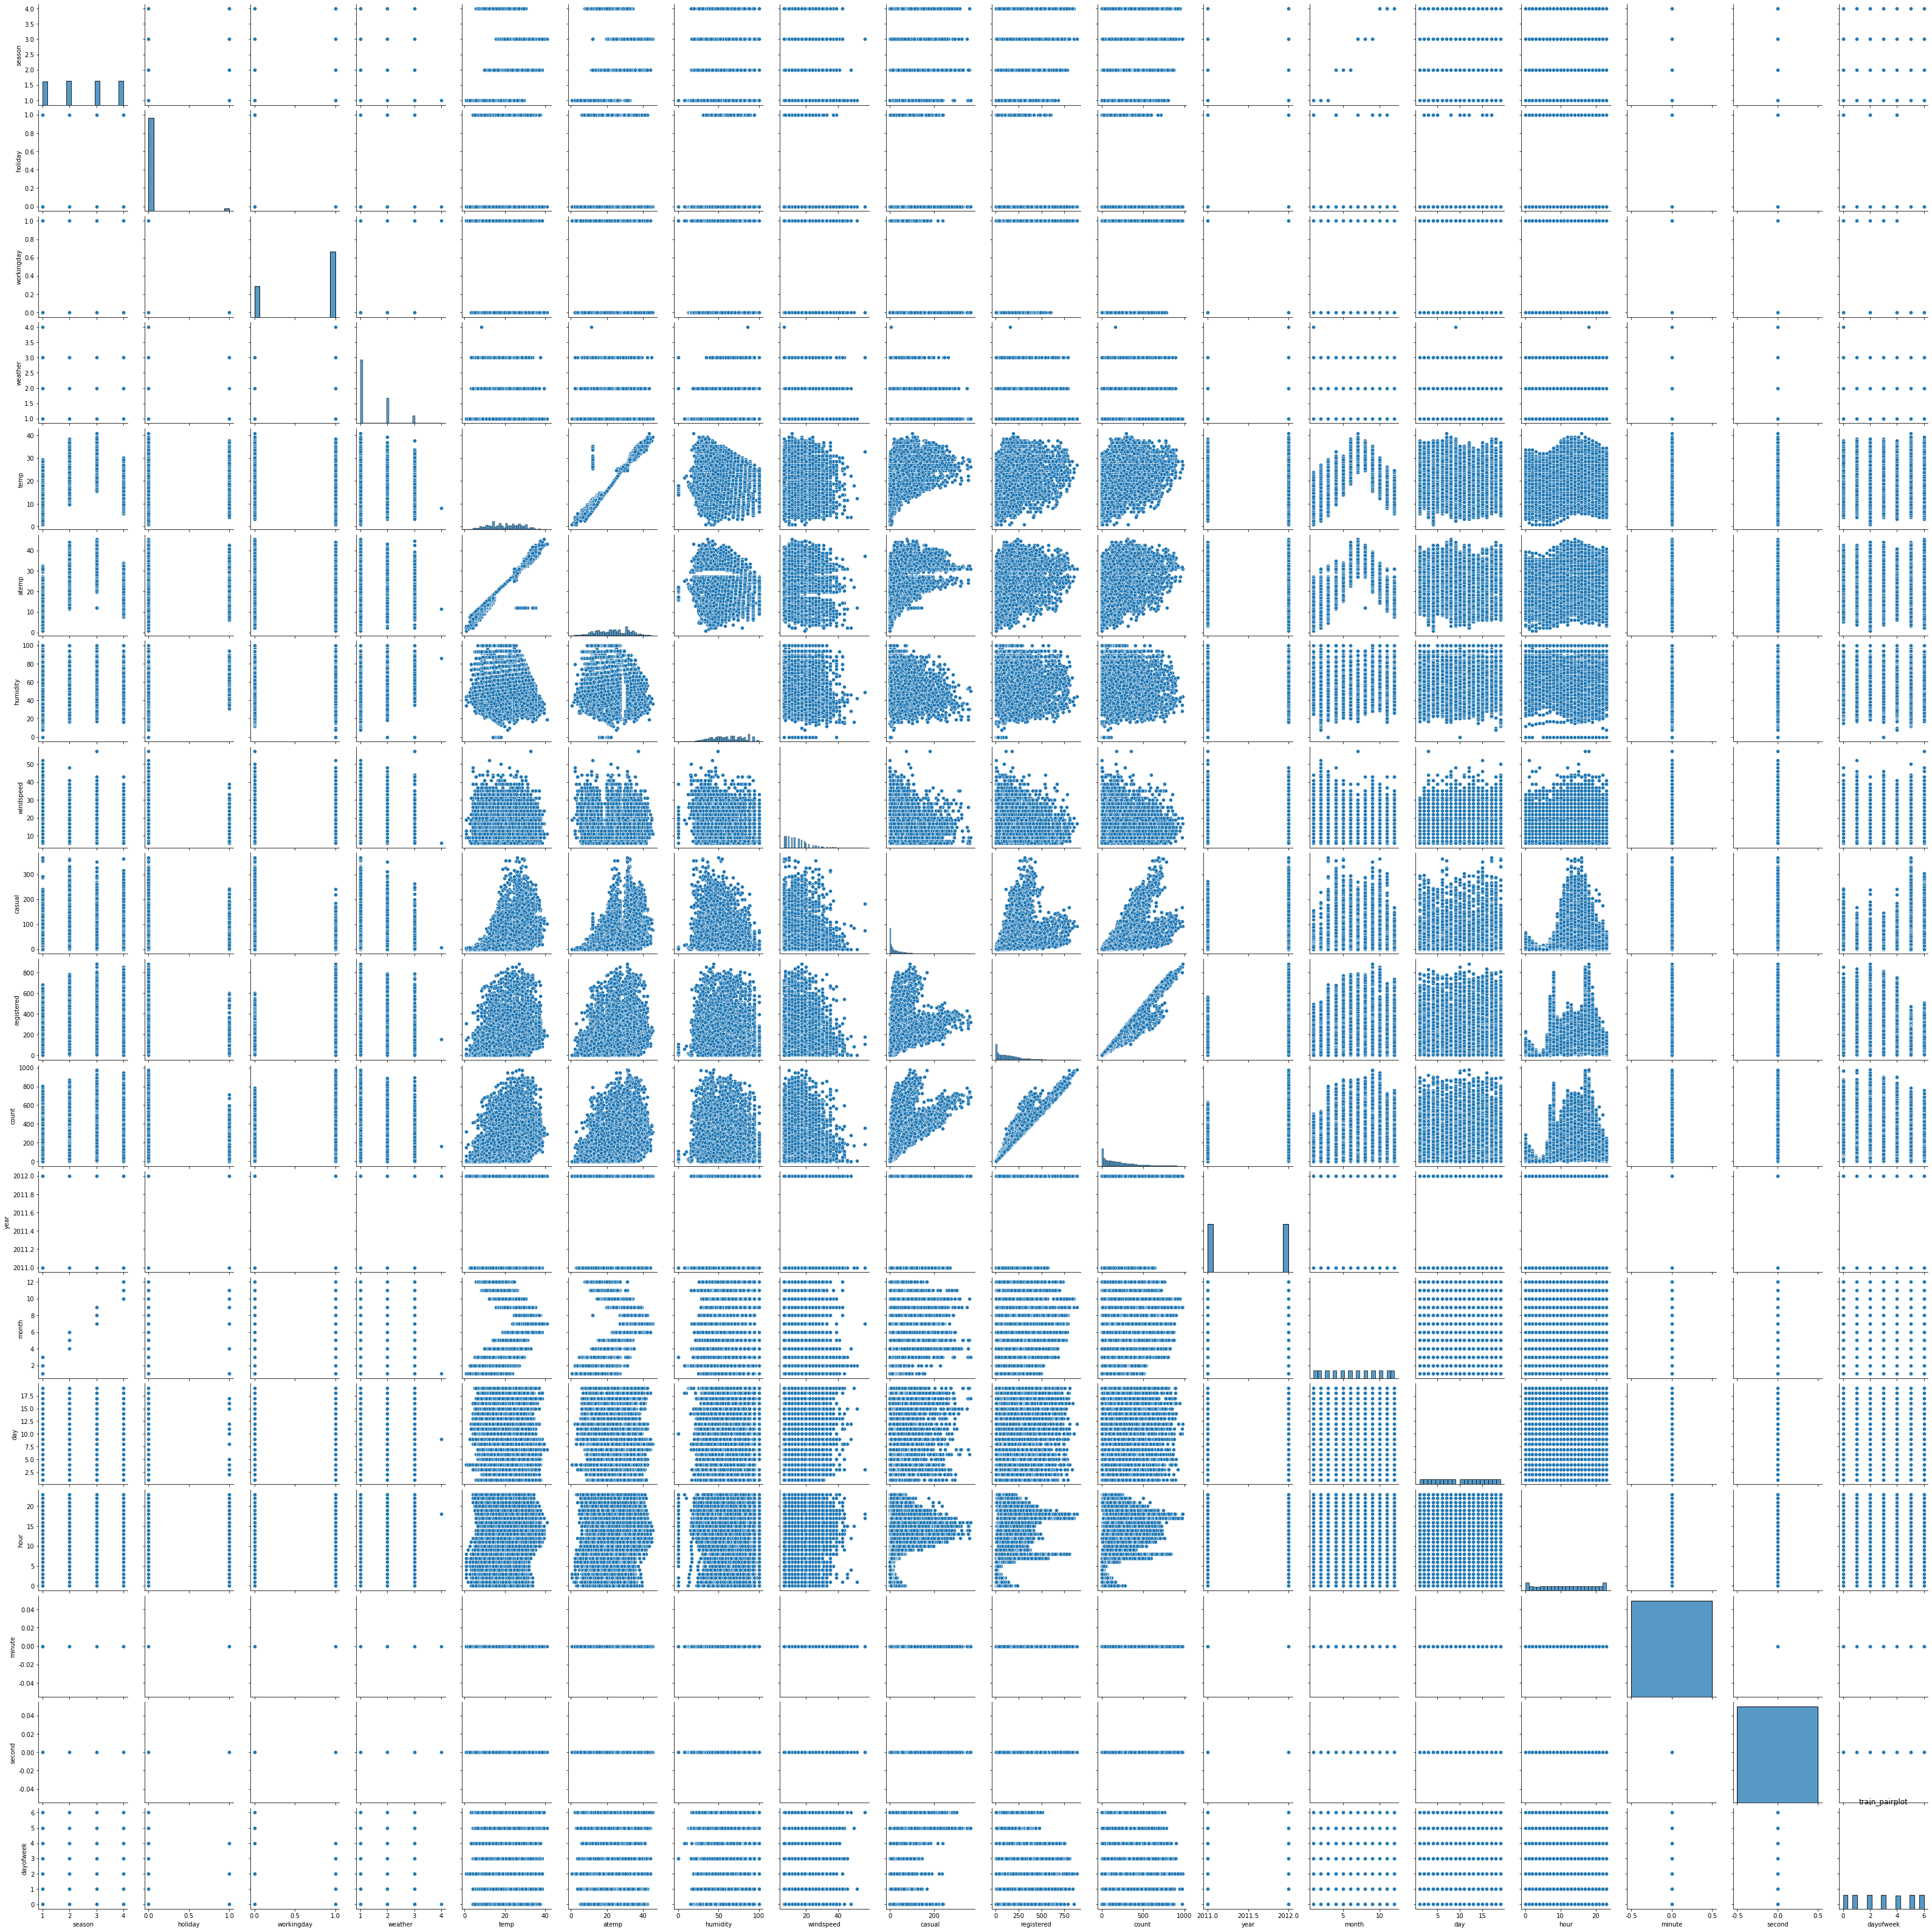

In [16]:
sns.pairplot(train)
plt.title('train_pairplot')
plt.show()

In [17]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [18]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

In [19]:
train[feature_names].head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [20]:
X_train = train[feature_names]
X_train.shape

(10886, 11)

In [21]:
X_test = test[feature_names]
X_test.shape, X_test.head()

((6493, 11),
   season weather   temp   atemp  humidity  windspeed  year hour dayofweek  \
 0      1       1  10.66  11.365        56    26.0027  2011    0         3   
 1      1       1  10.66  12.880        56    11.0014  2011    3         3   
 2      1       1  10.66  12.880        56    11.0014  2011    4         3   
 3      1       1   9.84  11.365        60    15.0013  2011    5         3   
 4      1       1   9.02  10.605        60    15.0013  2011    6         3   
 
   holiday workingday  
 0       0          1  
 1       0          1  
 2       0          1  
 3       0          1  
 4       0          1  )

In [22]:
label_name = 'count'
y_train = train[label_name]
y_train.shape, y_train.head()

((10886,),
 0     1
 1    36
 2    56
 3    84
 4    94
 Name: count, dtype: int64)

In [23]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 1을 더하는 이유는 0일때 마이너스 무한대가 되기 때문에 1을 더해주고 로그를 씌운다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10,shuffle=True,random_state=42)

In [25]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators=100, # 100개의 tree 생성
                              n_jobs=-1, # 모든 코어를 사용
                              random_state=42) # 시드값 고정
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
%time score = cross_val_score(model, X_train, y_train, cv=kfold, scoring=rmsle_scorer)

Wall time: 13.3 s


In [30]:
score.mean()
# 결과해석 : difference가 0이 나오는게 좋은 데이터

0.33106362529610817

In [31]:
# 학습
model.fit(X_train,y_train)

# 예측
pred = model.predict(X_test)

pred.shape, pred

((6493,), array([ 12.58,   3.62,   2.93, ..., 209.82,  60.98, 195.72]))

[Text(0.5, 1.0, 'test')]

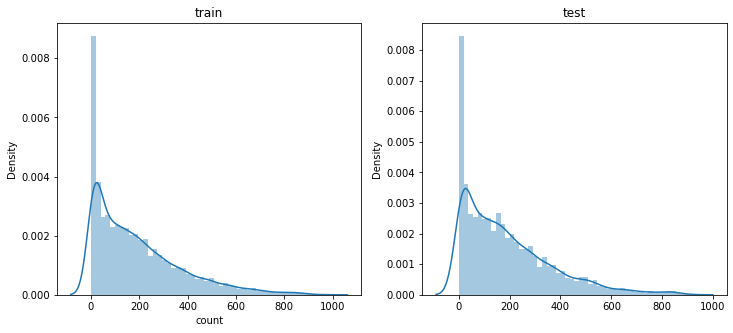

In [33]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(pred,ax=ax2,bins=50)
ax2.set(title="test")

# 선형회귀

In [35]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train) #log +1 
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds)))

RMSLE Value For Linear Regression:  0.9798838339297592


In [ ]:
# 릿지 Regularization Model - Ridge

# 회귀를 위한 선형모델
# 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
# Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
# max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [37]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9798838319121457


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009595,0.003876,0.002598,4.894343e-04,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.264761,-0.204261,-0.249520,-0.202772,-0.239998,-0.232262,0.024769,1
1,0.005796,0.000748,0.002998,1.548743e-03,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.264762,-0.204261,-0.249520,-0.202771,-0.239998,-0.232262,0.024770,2
2,0.005597,0.000490,0.001999,6.217196e-07,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.264772,-0.204264,-0.249519,-0.202764,-0.239996,-0.232263,0.024773,3
3,0.005397,0.000490,0.001998,5.519789e-07,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.264784,-0.204267,-0.249518,-0.202757,-0.239995,-0.232264,0.024777,4
4,0.005397,0.000490,0.002998,1.094931e-03,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.264795,-0.204270,-0.249517,-0.202749,-0.239993,-0.232265,0.024781,5


In [38]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232262
1,0.10,0.232262
2,1.00,0.232263
3,2.00,0.232264
4,3.00,0.232265


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

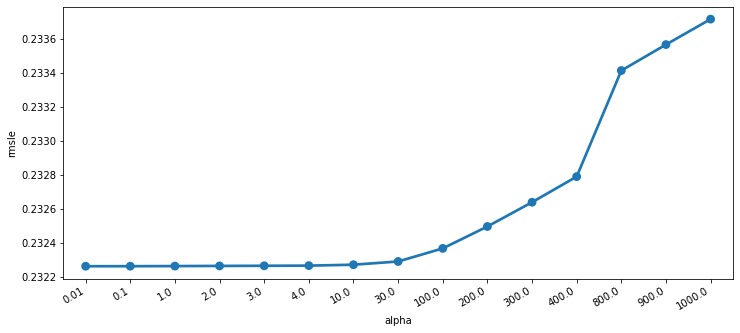

In [39]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [ ]:
# 라쏘 Regularization Model - Lasso

# 선형회귀의 Regularization(규제)를 적용하는 대안
# 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
# 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
# alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
# 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
# max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [40]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9798927008365318


,alpha,rmsle
0,10.000000,0.316789
1,1.000000,0.249640
2,0.500000,0.245344
3,0.333333,0.244172
4,0.250000,0.243621


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

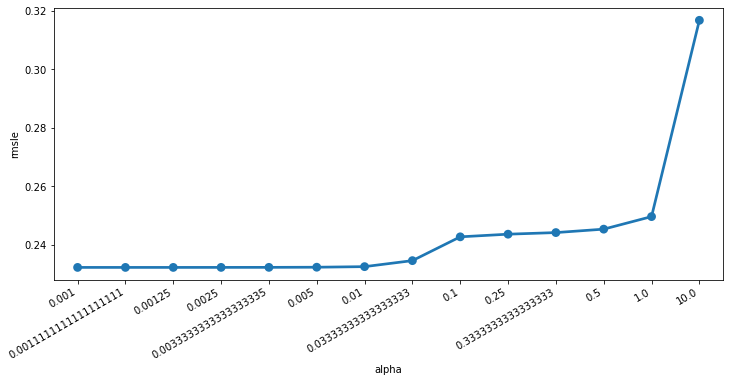

In [41]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [43]:
# 수정된 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

pred = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(pred))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10586791434745461


In [ ]:
# Ensemble Model - Gradient Boost

# 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
# 회귀와 분류에 모두 사용할 수 있음
# 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
# 무작위성이 없고 강력한 사전 가지치기가 사용 됨
# 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
# learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
# n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
# max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds)) # -1을 해주는게 원래 값일것같은데 그러면 오히려 성능 떨어짐
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21883190610561068


<AxesSubplot:ylabel='Density'>

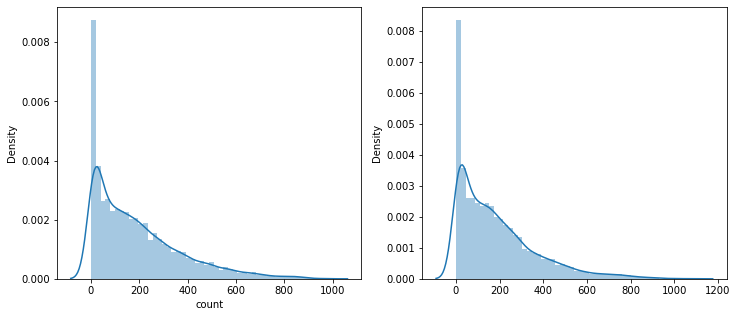

In [47]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [ ]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/bike/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)  # log 함수 >> exp() 변환해야 원래 값으로 환원

print(submission.shape)
submission.head()